# Assignment 3 - 3D Vision In The Wild

Class: COMP 5970 - Computer Vision

Author: Chris Hinkson

Email: cmh0201@auburn.edu

*Personal Contribution Statement: This was an individual project and I did everything in it.*

*Generative AI Declaration: TODO*

Assignment Table Of Contents:
1) TODO
***

#### Module Import / Config

The below code cell will import any needed modules for assignment 2 and configure them as necessary.

In [6]:
# System
import os
import requests
from tqdm import tqdm

# Data
import numpy as np

# Image Processing
from PIL import Image
from pillow_heif import register_heif_opener
import cv2

# Display
from IPython.display import display
import matplotlib.pyplot as plt


#### Resource Download

The below code cell will download any needed resources (images) for assignment 3.

In [7]:

# Create image directory if it does not exist
os.makedirs("../images", exist_ok=True)

# Define image names for this project
# imageNames = ["auburn.jpeg", "Part1_scene.png", "puzzle_reference.png", "puzzle_scrambled.png"]
# for imageName in tqdm(iterable=imageNames, desc="Downloading Images", unit="image"):
# 	if not os.path.exists(f"../images/{imageName}"):
# 		response = requests.get(f"https://github.com/cmh02/COMP5970---Computer-Vision/blob/main/Assignment%202%20-%20Feature%20Manipulation/images/{imageName}?raw=true")
# 		with open(f"../images/{imageName}", "wb") as imageFile:
# 			imageFile.write(response.content)
# 		print(f"-> Saved {imageName} to ../images/{imageName}!")
# 	else:
# 		print(f"-> File {imageName} already exists!")


***
## Task 1 Report: Stereo Vision

#### Task 1 Description

Task 1 


left and right
3 objects - clarity goodie cup, bag of bagels, preworkout

#### Task 1 Report Table of Contents

***

#### Task 1 Implementation: Image Loading

This section will load the two images I took.

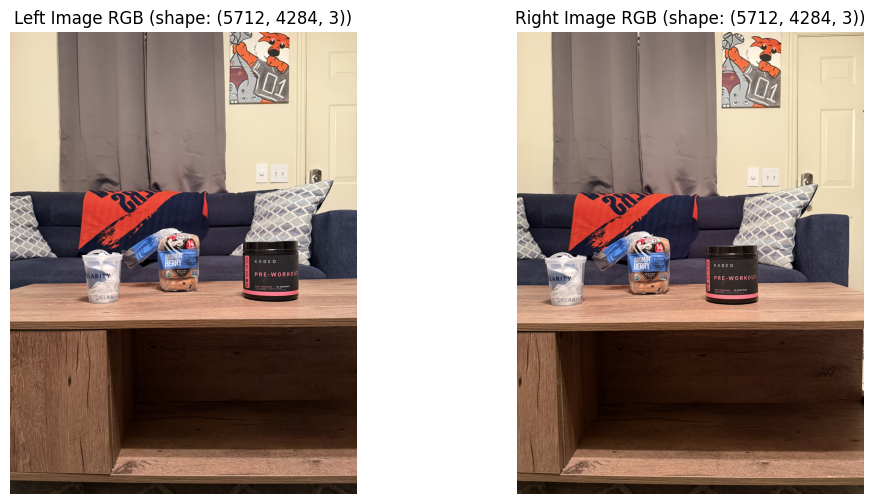

In [8]:
# Setup for HEIC loading
register_heif_opener()

# Load the images
imageLeft_rgb = np.array(Image.open("../images/image_left.heic").convert("RGB"))
imageRight_rgb = np.array(Image.open("../images/image_right.heic").convert("RGB"))

# Save images as PNG for easier future loading
Image.fromarray(imageLeft_rgb).save("../images/image_left.png")
Image.fromarray(imageRight_rgb).save("../images/image_right.png")

# Reload images from PNG with cv2 instead of pillow
imageLeft_rgb = cv2.cvtColor(cv2.imread("../images/image_left.png"), cv2.COLOR_BGR2RGB)
imageRight_rgb = cv2.cvtColor(cv2.imread("../images/image_right.png"), cv2.COLOR_BGR2RGB)

# Convert images to grayscale
imageLeft_grayscale = cv2.cvtColor(np.array(imageLeft_rgb), cv2.COLOR_RGB2GRAY)
imageRight_grayscale = cv2.cvtColor(np.array(imageRight_rgb), cv2.COLOR_RGB2GRAY)

# Display the images and image properties
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(imageLeft_rgb)
axes[0].set_title(f"Left Image RGB (shape: {imageLeft_rgb.shape})")
axes[0].axis("off")
axes[1].imshow(imageRight_rgb)
axes[1].set_title(f"Right Image RGB (shape: {imageRight_rgb.shape})")
axes[1].axis("off")
plt.show()

#### Task 1 Implementation: Detect and Match Features

This section will detect and match features between the two images I captured.

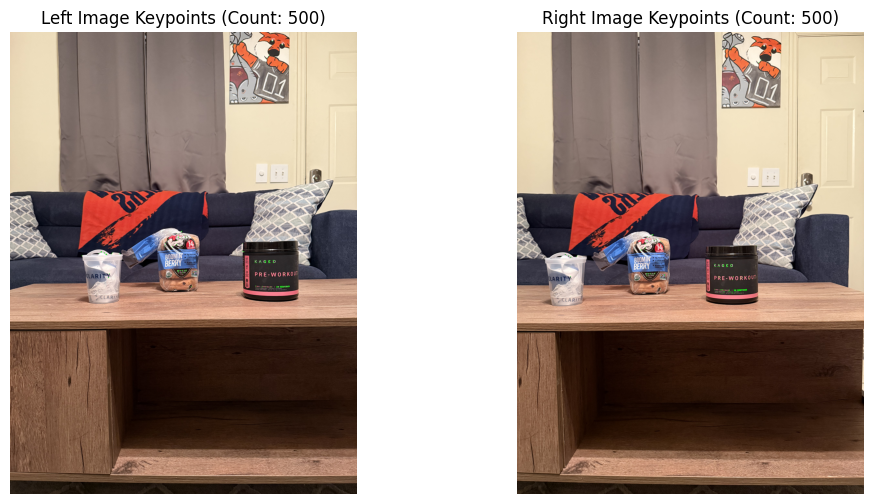

In [17]:
# Create ORB for keypoint detection and descriptor extraction
orb = cv2.ORB_create()
imageLeft_keypoints, imageLeft_descriptors = orb.detectAndCompute(imageLeft_grayscale, None)
imageRight_keypoints, imageRight_descriptors = orb.detectAndCompute(imageRight_grayscale, None)

# Draw keypoints on the images
imageLeft_keypointsDrawnOnImage = cv2.drawKeypoints(image=imageLeft_rgb, keypoints=imageLeft_keypoints, outImage=None, color=(0, 255, 0))
imageRight_keypointsDrawnOnImage = cv2.drawKeypoints(image=imageRight_rgb, keypoints=imageRight_keypoints, outImage=None, color=(0, 255, 0))

# Display the images with keypoints drawn on them
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(imageLeft_keypointsDrawnOnImage)
axes[0].set_title(f"Left Image Keypoints (Count: {len(imageLeft_keypoints)})")
axes[0].axis("off")
axes[1].imshow(imageRight_keypointsDrawnOnImage)
axes[1].set_title(f"Right Image Keypoints (Count: {len(imageRight_keypoints)})")
axes[1].axis("off")
plt.show()

#### Task 1 Implementation: Feature Matching

This section will use FLANN to match features between the two stereo images.

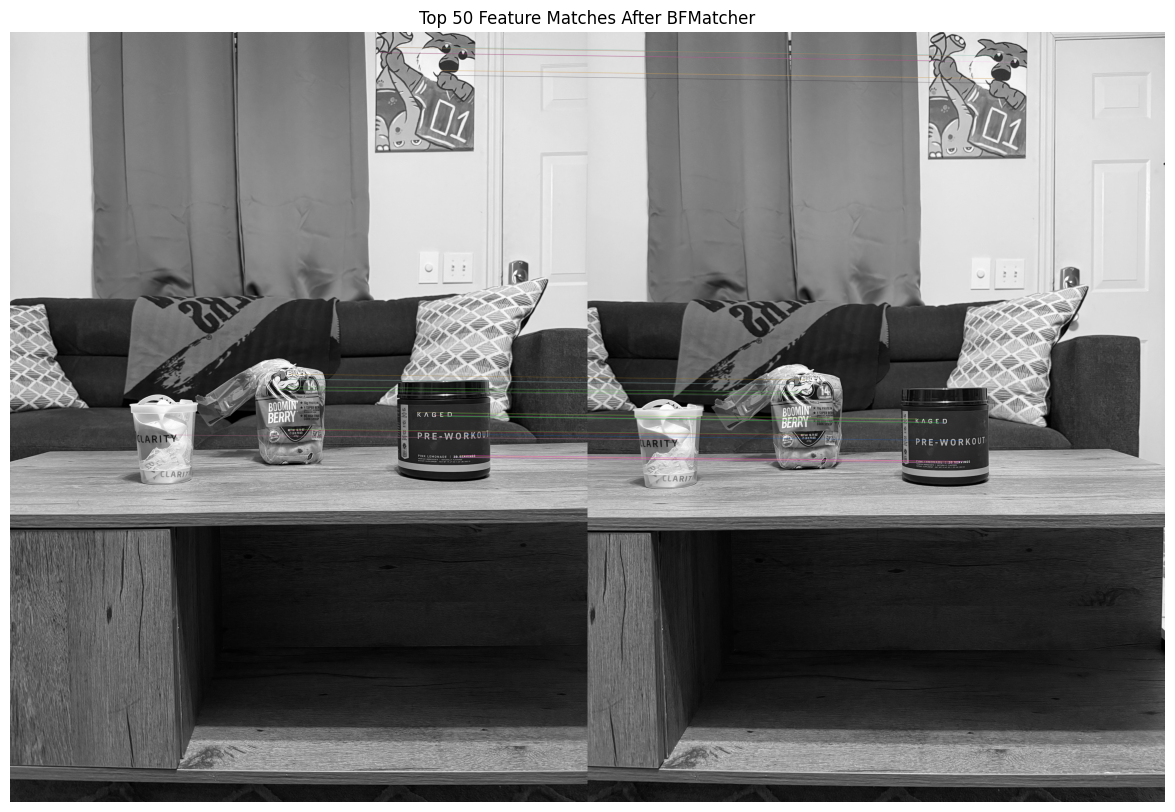

In [18]:
# Match features with Brute-Force and Hamming distance
bfmatcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bfmatcher.match(imageLeft_descriptors, imageRight_descriptors)
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches and display
img_matches = cv2.drawMatches(
	img1=imageLeft_grayscale, 
	keypoints1=imageLeft_keypoints, 
	img2=imageRight_grayscale, 
	keypoints2=imageRight_keypoints, 
	matches1to2=matches[:50], 
	outImg=None, 
	flags=2
    )
plt.figure(figsize=(15, 10))
plt.title("Top 50 Feature Matches After BFMatcher")
plt.imshow(img_matches, cmap='gray')
plt.axis('off')
plt.show()

#### Task 1 Implementation: Fundamental Matrix and Epipolar Lines

This section will estimate the fundamental matrix and draw epipolar lines.

Estimated Fundamental Matrix:
[[-1.89091756e-08 -2.37222083e-06  6.61309878e-03]
 [ 2.28806342e-06 -4.51759343e-07 -2.27098347e-02]
 [-6.25674686e-03  2.38287029e-02  1.00000000e+00]]


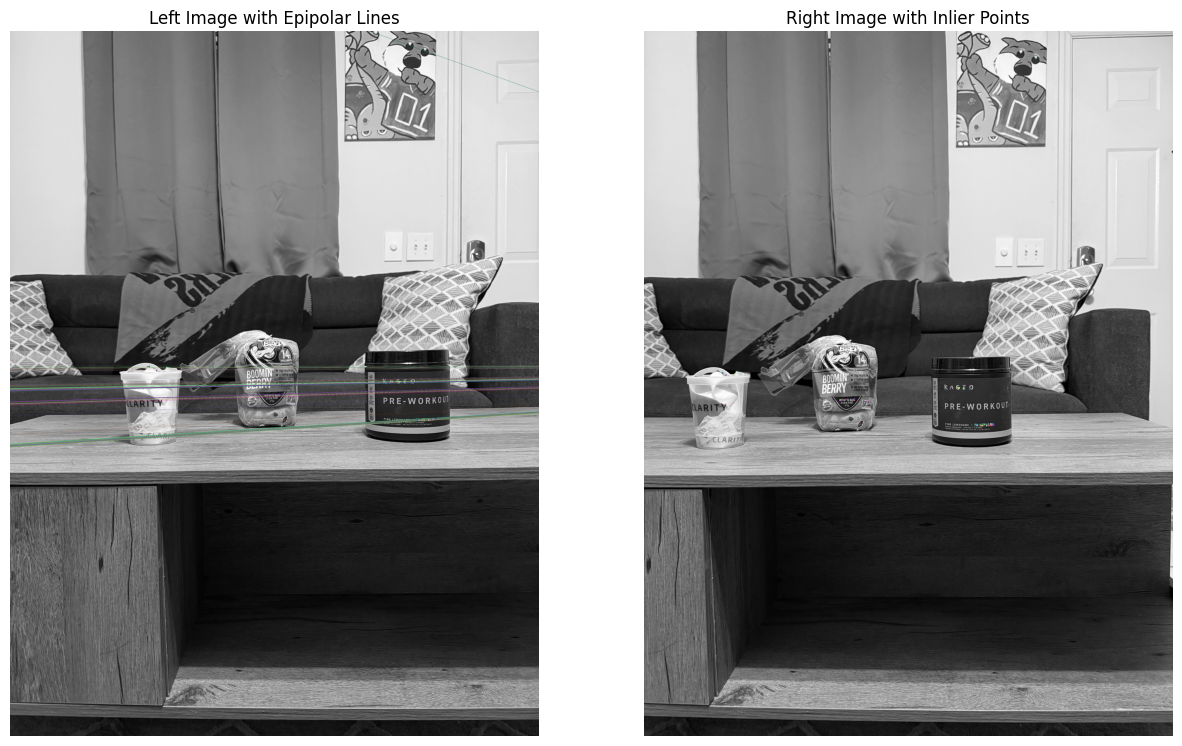

In [19]:
# Extract location of good matches
imageLeft_matchPoints = np.float32([imageLeft_keypoints[match.queryIdx].pt for match in matches])
imageRight_matchPoints = np.float32([imageRight_keypoints[match.trainIdx].pt for match in matches])

# Estimate the fundamental matrix using cv2 with RANSAC
fundamentalMatrix, mask = cv2.findFundamentalMat(imageLeft_matchPoints, imageRight_matchPoints, cv2.FM_RANSAC)
print(f"Estimated Fundamental Matrix:\n{fundamentalMatrix}")

# Keep only inliers
imageLeft_matchPoints_inliers = imageLeft_matchPoints[mask.ravel() == 1]
imageRight_matchPoints_inliers = imageRight_matchPoints[mask.ravel() == 1]

# Utility function for drawing epipolar lines
def drawEpipolarLines(img1, img2, lines, pts1, pts2):
	'''
	Function to draw epipolar lines on the images given the lines and points.
	Code taken from Dr. Aakur's lecture notebook (I aslo found it on openCV tutorial,
	so I assume it's from there originally).
	'''
	r, c = img1.shape
	img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
	img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
	for r, pt1, pt2 in zip(lines, pts1, pts2):
		color = tuple(np.random.randint(0, 255, 3).tolist())
		x0, y0 = map(int, [0, -r[2] / r[1]])
		x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
		img1_color = cv2.line(img1_color, (x0, y0), (x1, y1), color, 1)
		img1_color = cv2.circle(img1_color, tuple(map(int, pt1)), 5, color, -1)
		img2_color = cv2.circle(img2_color, tuple(map(int, pt2)), 5, color, -1)
	return img1_color, img2_color

# Compute epilines for points in right image and draw them on the left image
imageLeft_lines = cv2.computeCorrespondEpilines(imageRight_matchPoints_inliers.reshape(-1, 1, 2), 2, fundamentalMatrix)
imageLeft_lines = imageLeft_lines.reshape(-1, 3)
imageLeft_withEpilines, imageRight_withPoints = drawEpipolarLines(imageLeft_grayscale, imageRight_grayscale, imageLeft_lines, imageLeft_matchPoints_inliers, imageRight_matchPoints_inliers)

# Display the images with epilines
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(imageLeft_withEpilines)
axs[0].set_title("Left Image with Epipolar Lines")
axs[0].axis("off")
axs[1].imshow(imageRight_withPoints)
axs[1].set_title("Right Image with Inlier Points")
axs[1].axis("off")
plt.show()